In [9]:
import numpy as np
import scipy
import sklearn
try:
  import netCDF4 as nc
except :
  !pip install netCDF4
import netCDF4
import xarray as xr
import matplotlib.pyplot as plt
import copy

In [10]:
from math import inf

class Mpav():

  def __init__(self,numbers : list,y = 0):
    self.numbers = numbers
    self.elements = [[numbers[i],set([i])] for i in range(len(numbers))]
    self.y = y

  def computes_slope(self, i:int):
    return (self.s_i(i-1)-self.s_i(i))/len(self.elements[i][1])

  def collision_time(self, i :int):
    if self.computes_slope(i)-self.computes_slope(i+1) == 0 :
      return inf
    return (self.elements[i+1][0]-self.elements[i][0])/(self.computes_slope(i)-self.computes_slope(i+1)) + self.y

  def compute_critical_y(self):
    mini = inf
    K_y = len(self.elements)
    for i in range(K_y-1):
      t = self.collision_time(i)
      if t < mini and t >= self.y:
        mini = self.collision_time(i)
    return mini

  def index_merge(self):
    mini = self.compute_critical_y()
    K_y = len(self.elements)
    for i in range(K_y-1):
      if self.collision_time(i) == mini:
        return i
    return False

  def update_betas(self):
    y2 = self.compute_critical_y()
    for i in range(len(self.elements)):
      self.elements[i][0] += self.computes_slope(i)*(y2-self.y)

  def merge(self):
    index = self.index_merge()
    # merge A_i et A_i+1
    self.elements[index][1] = self.elements[index][1].union(self.elements[index+1][1])
    self.elements.pop(index+1)
    return True

  def update_y(self):
    self.y = self.compute_critical_y()


  def s_i(self,i):
    if i == 0 or i >= len(self.elements)-1:
      return 0
    return 1 if self.elements[i][0] > self.elements[i+1][0] else 0

  def MSE_loss(self):
    loss = 0
    for i in range(len(self.elements)):
      A_i = self.elements[i][1]
      beta_i = self.elements[i][0]
      for j in A_i :
        loss += (self.numbers[j]-beta_i)**2
      loss += self.y * self.s_i(i)
    return loss

  def run_mpav(self):
    history = []
    while True :
      mini = self.compute_critical_y()
      history.append((copy.deepcopy(self.y), copy.deepcopy(self.elements)))
      if mini == inf :
        return history

      self.update_betas()
      self.merge()
      self.update_y()


In [11]:
numbers = [1,2,2,3,1,2,3,4,5,5,6,7,5,5,8,9,8,10,12,15,13,16]
reg = Mpav(numbers = numbers)
history = reg.run_mpav()

In [12]:
modified_history = []
for element in history :
  if len(modified_history) > 0 and element[0] == modified_history[-1][0]:
    modified_history[-1] = element
  else :
    modified_history.append(element)

/tmp/ipython-input-2766966060.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


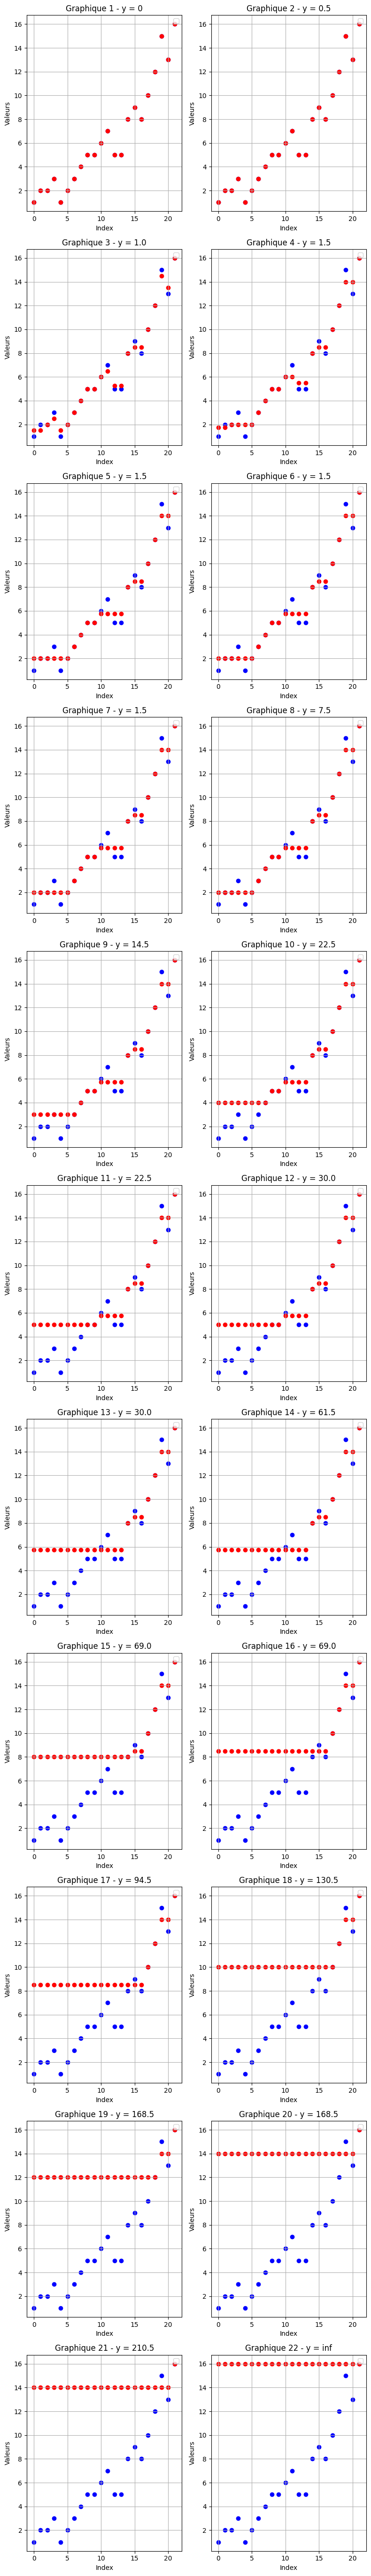

In [13]:
from math import ceil
# Déterminer la disposition de la grille
n_graphs = len(history)
ncols = 2  # Nombre de colonnes souhaité
nrows = ceil(n_graphs / ncols)  # Calcul du nombre de lignes nécessaires

# Création des sous-figures
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 5 * nrows))

# Aplatir axs pour itérer facilement, même s'il est en 2D
axs = axs.flatten()

# Tracé des sous-graphiques
for count, (y, elements) in enumerate(history):
    ax = axs[count]

    # Courbe originale en bleu
    ax.scatter(range(len(numbers)), numbers, color='blue')

    # Régression en rouge
    for element in elements:
        beta_i = element[0]  # La valeur de beta_i
        A_i = element[1]  # Ensemble d'indices
        ax.scatter(list(A_i), [beta_i] * len(A_i), color="red")

    # Personnalisation
    ax.set_title(f"Graphique {count + 1} - y = {y}")
    ax.set_xlabel("Index")
    ax.set_ylabel("Valeurs")
    ax.legend()
    ax.grid(True)

# Supprimer les sous-graphiques inutilisés si la grille est trop grande
for i in range(n_graphs, len(axs)):
    fig.delaxes(axs[i])

# Ajustement de l'espacement
plt.tight_layout()
plt.show()

In [14]:
modified_history = [modified_history[0],modified_history[2],modified_history[5],modified_history[9]]

/tmp/ipython-input-2591483650.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


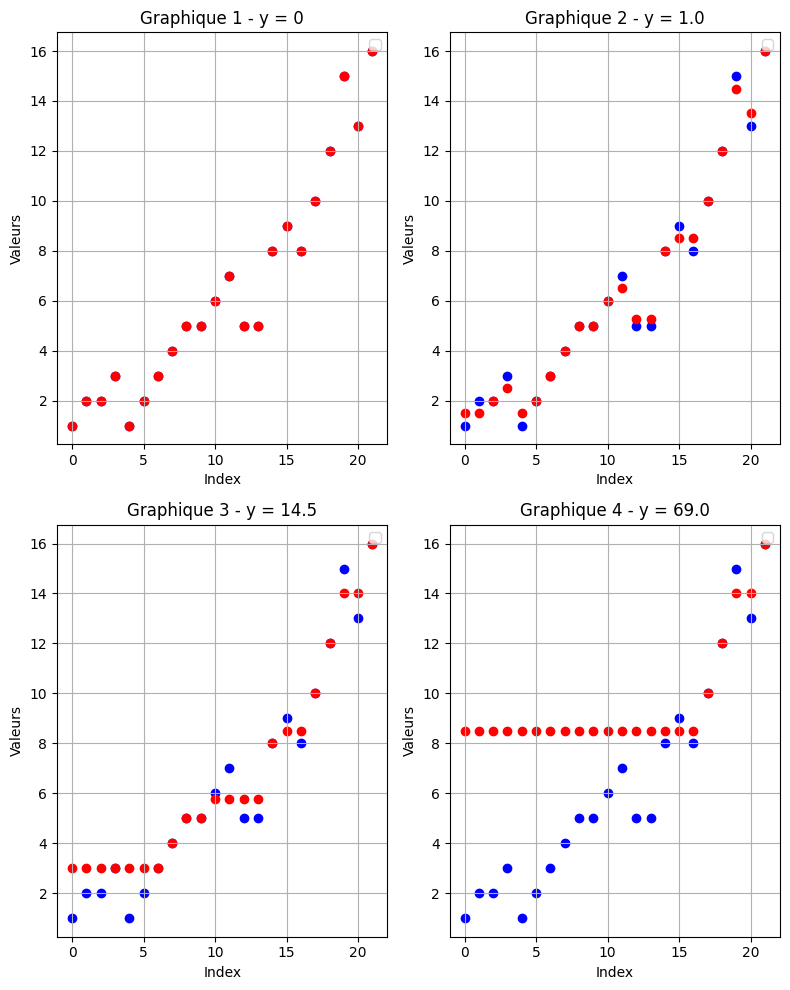

In [15]:
from math import ceil
# Déterminer la disposition de la grille
n_graphs = len(modified_history)
ncols = 2  # Nombre de colonnes souhaité
nrows = ceil(n_graphs / ncols)  # Calcul du nombre de lignes nécessaires

# Création des sous-figures
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 5 * nrows))

# Aplatir axs pour itérer facilement, même s'il est en 2D
axs = axs.flatten()

# Tracé des sous-graphiques
for count, (y, elements) in enumerate(modified_history):
    ax = axs[count]

    # Courbe originale en bleu
    ax.scatter(range(len(numbers)), numbers, color='blue')

    # Régression en rouge
    for element in elements:
        beta_i = element[0]  # La valeur de beta_i
        A_i = element[1]  # Ensemble d'indices
        ax.scatter(list(A_i), [beta_i] * len(A_i), color="red")

    # Personnalisation
    ax.set_title(f"Graphique {count + 1} - y = {y}")
    ax.set_xlabel("Index")
    ax.set_ylabel("Valeurs")
    ax.legend()
    ax.grid(True)

# Supprimer les sous-graphiques inutilisés si la grille est trop grande
for i in range(n_graphs, len(axs)):
    fig.delaxes(axs[i])

# Ajustement de l'espacement
plt.tight_layout()
plt.show()